# Setup

In [1]:
#### Dependencies ####
import numpy as np
import logging
import os
import sys
import time
import joblib
import matplotlib.pyplot as plt
import torch
import json
import cortex # This dependency is pycortex, which enables the plotting of flatmaps. It can be disabled.
from cvxopt import matrix, solvers # Only necessary for the stacked model.
from transformers import AutoTokenizer, AutoModelForCausalLM # Only necessary for feature extraction.
import subprocess
from tqdm.autonotebook import tqdm, trange

# Repository imports
from ridge_utils.ridge import bootstrap_ridge
import ridge_utils.npp
from ridge_utils.util import make_delayed
from ridge_utils.dsutils import make_word_ds
from ridge_utils.DataSequence import DataSequence
from ridge_utils.tokenization_helpers import generate_efficient_feat_dicts_opt
from ridge_utils.tokenization_helpers import convert_to_feature_mats_opt

# Topic model imports
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer # For generating embeddings
from sklearn.decomposition import PCA # To speed up the UMAP
from sklearn.feature_extraction.text import CountVectorizer 
from bertopic.vectorizers import ClassTfidfTransformer
try:
    import en_core_web_sm
except ModuleNotFoundError:
    !python -m spacy download en_core_web_sm
    import en_core_web_sm
from bertopic.representation import PartOfSpeech, KeyBERTInspired, MaximalMarginalRelevance

## User defined variables

In [2]:
## Paths for the the story data and FMRI data
grids_path = "../data/story_data/grids_huge.jbl"
trfiles_path = "../data/story_data/trfiles_huge.jbl"

## Paths for the topic encoder
model_dir = "../models"
embeddings_dir = "../embeddings"

## If there are any pre-trained models you'd like to use
model_path = None

# If embeddings have been pre-computed
embeddings_path = None

## Download cortex data
Here we automate the download of the brain models from open-neuro. It uses curl to download the files, and then sets the cortex path to be the correct location for us.

In [3]:
pycortex_download_script = "../ds003020-2.2.0.sh"
pycortex_dir = '../pycortex-db'

# Select which subjects to download (full list is ['UTS01', 'UTS02','UTS03','UTS04','UTS05','UTS06','UTS07','UTS08'] ) 
subjects = ['UTS03']

with open(pycortex_download_script, 'r') as f:
    pbar = tqdm(f)
    for line in pbar:
        if 'derivative/pycortex-db/UTS' in line:
            for subject in subjects:
                if subject in line:
                    # Construct the output command
                    output_command = line.replace(' derivative/pycortex-db/', ' ' + pycortex_dir + os.sep)
                    
                    # Extract the output file path from the curl command
                    # Assuming the output path is specified with -o option in the curl command
                    parts = output_command.split()
                    output_file_path = None
                    if '-o' in parts:
                        output_file_index = parts.index('-o') + 1
                        output_file_path = parts[output_file_index]
                    
                    # Check if the file exists
                    if output_file_path and not os.path.exists(output_file_path):
                        subprocess.run(output_command, shell=True)
                    else:
                        pbar.set_description(f"File {output_file_path} already exists. Skipping download.")

# This is your new filestore path
new_filestore_path = os.path.join(os.getcwd(), pycortex_dir)
cortex.options.config.set('basic', 'filestore', new_filestore_path)
# Set the new filestore path
cortex.db.filestore = cortex.options.config.get('basic', 'filestore')
cortex.db.reload_subjects()
cortex.db

0it [00:00, ?it/s]

Pycortex database
  Subjects:
   UTS01
   UTS02
   UTS03

## GPU Setup

Sets up the GPU if there is one there. Biggest benefit will be on CUDA systems, some benefits exist for MacOS 

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use MPS if available
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Fallback to CUDA or CPU

# Load a model

In [5]:
model_path = "../models/test_model"
topic_model = BERTopic.load(model_path)
topic_model.get_topic_info()

Topic  Count                                  Name  \
0       -1  66961    -1_lived_lucky_bedroom_like little   
1        0   8265              0_proud_mike_uh uh_um uh   
2        1   6293          1_channel_love_english_loves   
3        2   2463  2_said yes_said yeah_uh said_said uh   
4        3   1869          3_patients_doctor_dr_patient   
..     ...    ...                                   ...   
459    458     11         458_needs_wants_desire_things   
460    459     11        459_shelter_slept_history_mean   
461    460     11     460_cared_care_don care_don worry   
462    461     10      461_office_deliver_notes_rolling   
463    462     10            462_saint_st_day_residents   

                                        Representation  Representative_Docs  
0    [lived, lucky, bedroom, like little, girls, la...                  NaN  
1    [proud, mike, uh uh, um uh, michael, uh um, fr...                  NaN  
2    [channel, love, english, loves, loving, sight,...                  NaN  
3    [said yes, said yeah, uh said, said uh, said s...                  NaN  
4    [patients, doctor, dr, patient, hospital, brig...                  NaN  
..                                                 ...                  ...  
459  [needs, wants, desire, things, sentence, neede...                  NaN  
460  [shelter, slept, history, mean, women, months,...                  NaN  
461  [cared, care, don care, don worry, worry, real...                  NaN  
462  [office, deliver, notes, rolling, note, write,...                  NaN  
463  [saint, st, day, residents, know, house, story...                  NaN  

[464 rows x 5 columns]

In [6]:
topic_model.visualize_topics()

In [7]:
test_strings = [
    "The ocean's vast expanse stretches endlessly, meeting the sky at a distant horizon.",
    "Waves crash rhythmically against the sandy shore, creating a soothing symphony of sounds.",
    "Sunlight sparkles on the water's surface, creating a tapestry of shimmering light.",
    "Seagulls glide gracefully overhead, their calls echoing the mystery of the sea.",
    "The salty breeze brushes against your skin, invigorating your senses with its freshness.",
    "Children build elaborate sandcastles near the water’s edge, their laughter mingling with the ocean's roar.",
    "The beach at sunset offers a breathtaking view, with hues of orange and pink painting the sky.",
    "Collecting seashells along the shore, each one tells a unique story from beneath the waves.",
    "Surfers challenge the mighty waves, skillfully maneuvering their boards in sync with the ocean’s rhythm.",
    "The smell of the ocean, a mix of salt and mystery, fills the air, instantly relaxing anyone who breathes it in."
]

topics, probs = topic_model.transform(test_strings)

In [8]:
topics

array([ 83, 220,  81,  47,  79,  16,  81,   7, 220,  79])

In [9]:
# check a single topic
id = 5
print(test_strings[id])
topic_model.get_topic_info(topics[id])

Children build elaborate sandcastles near the water’s edge, their laughter mingling with the ocean's roar.


Topic  Count                                 Name  \
0     16    983  16_child_daughter_children_year old   

                                      Representation  Representative_Docs  
0  [child, daughter, children, year old, infant, ...                  NaN

In [10]:
def normalize_probs(probs):
    """
    Normalize the given probability values.

    Parameters:
    probs (numpy.ndarray): The probability values to be normalized.

    Returns:
    numpy.ndarray: The normalized probability values.

    """
    max_probs = np.max(probs, axis=1)
    min_probs = np.min(probs, axis=1)
    norm_probs = (probs - min_probs) / (max_probs - min_probs)
    return norm_probs

In [11]:
def make_semantic_model_topic_model(ds,topic_model):
    total_len = len(ds.data)
    num_topics = len(topic_model.get_topic_info())
    newdata = []
    lookback = 64
    for i, w in enumerate(ds.data):
        if w != '':
            text = [" ".join(ds.data[max(0,i-lookback):min(i+1,total_len)])]
            _, probs = topic_model.transform(text)
            feat = normalize_probs(probs)
            newdata.append(np.array(feat.cpu()))
        else:
            newdata.append(np.zeros((num_topics,)))
    return DataSequence(np.array(newdata), ds.split_inds, ds.data_times, ds.tr_times)

In [12]:
str = "The doctor was very kind and helpful. He listened to my concerns and answered all of my questions. I felt comfortable and well taken care of during my visit. I would highly recommend this doctor to anyone in need of medical care."

topic, probs = topic_model.transform([str])

In [13]:
topic

array([3])

In [14]:
norm = normalize_probs(probs)
np.argmax(norm)

4

In [15]:
topic_model.get_topic_info()

Topic  Count                                  Name  \
0       -1  66961    -1_lived_lucky_bedroom_like little   
1        0   8265              0_proud_mike_uh uh_um uh   
2        1   6293          1_channel_love_english_loves   
3        2   2463  2_said yes_said yeah_uh said_said uh   
4        3   1869          3_patients_doctor_dr_patient   
..     ...    ...                                   ...   
459    458     11         458_needs_wants_desire_things   
460    459     11        459_shelter_slept_history_mean   
461    460     11     460_cared_care_don care_don worry   
462    461     10      461_office_deliver_notes_rolling   
463    462     10            462_saint_st_day_residents   

                                        Representation  Representative_Docs  
0    [lived, lucky, bedroom, like little, girls, la...                  NaN  
1    [proud, mike, uh uh, um uh, michael, uh um, fr...                  NaN  
2    [channel, love, english, loves, loving, sight,...                  NaN  
3    [said yes, said yeah, uh said, said uh, said s...                  NaN  
4    [patients, doctor, dr, patient, hospital, brig...                  NaN  
..                                                 ...                  ...  
459  [needs, wants, desire, things, sentence, neede...                  NaN  
460  [shelter, slept, history, mean, women, months,...                  NaN  
461  [cared, care, don care, don worry, worry, real...                  NaN  
462  [office, deliver, notes, rolling, note, write,...                  NaN  
463  [saint, st, day, residents, know, house, story...                  NaN  

[464 rows x 5 columns]

In [16]:
# These files are located in the story_data folder of the Box
# We'll build an encoding model using this set of stories for this tutorial.
train_stories = ['adollshouse', 'adventuresinsayingyes', 'alternateithicatom', 'avatar', 'buck', 'exorcism',
            'eyespy', 'fromboyhoodtofatherhood', 'hangtime', 'haveyoumethimyet', 'howtodraw', 'inamoment',
            'itsabox', 'legacy', 'naked', 'odetostepfather', 'sloth',
            'souls', 'stagefright', 'swimmingwithastronauts', 'thatthingonmyarm', 'theclosetthatateeverything',
            'tildeath', 'undertheinfluence']

test_stories = ["wheretheressmoke"]

# Load the data if it hasn't already been loaded. It's been put in a try except to only load it if 
# it's not been defined so we can easily re-run the whole notebook without having to do too much processing

try:
    wordseqs
except NameError:
    grids = joblib.load(grids_path) # Load TextGrids containing story annotations
    trfiles = joblib.load(trfiles_path) # Load TRFiles containing TR information

    # Filter out the other stories for the tutorial
    for story in list(grids):
        if story not in (train_stories + test_stories):
            del grids[story]
            del trfiles[story]

    # Make datasequence for story
    wordseqs = make_word_ds(grids, trfiles)

In [17]:
def normalize_probs(probs):
    """
    Normalize the given probability values.
    Parameters:
    probs (numpy.ndarray): The probability values to be normalized.
    Returns:
    numpy.ndarray: The normalized probability values.
    """
    max_probs = np.max(probs, axis=1)
    min_probs = np.min(probs, axis=1)
    norm_probs = (probs - min_probs) / (max_probs - min_probs)
    return norm_probs

In [18]:
def make_semantic_model_topic_model(ds, topic_model):
    """
    Creates a semantic model using a topic model.

    Args:
        ds (DataSequence): The input data sequence.
        topic_model: The topic model used for transformation.

    Returns:
        DataSequence: The transformed data sequence.
    """
    total_len = len(ds.data)
    num_topics = len(topic_model.get_topic_info())
    newdata = []
    lookback = 64
    pbar = tqdm(enumerate(ds.data), total=len(ds.data))
    for i, w in pbar:
        if w != '':
            text = [" ".join(ds.data[max(0, i - lookback):min(i + 1, total_len)])]
            _, probs = topic_model.transform(text)
            feat = normalize_probs(probs)
            newdata.append(np.array(feat))
        else:
            newdata.append(np.zeros((1, num_topics)))
    return DataSequence(np.squeeze(newdata), ds.split_inds, ds.data_times, ds.tr_times)

In [22]:
downsampled_featureseqs = {}
for story in tqdm(train_stories+test_stories):
    downsampled_featureseqs[story] = make_semantic_model_topic_model(wordseqs[story],topic_model).chunksums('lanczos', window=3)
logging.basicConfig(level=logging.INFO)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/1656 [00:00<?, ?it/s]

  0%|          | 0/2309 [00:00<?, ?it/s]

  0%|          | 0/2174 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

  0%|          | 0/1677 [00:00<?, ?it/s]

  0%|          | 0/2949 [00:00<?, ?it/s]

  0%|          | 0/2336 [00:00<?, ?it/s]

  0%|          | 0/2755 [00:00<?, ?it/s]

  0%|          | 0/1927 [00:00<?, ?it/s]

  0%|          | 0/2985 [00:00<?, ?it/s]

  0%|          | 0/1964 [00:00<?, ?it/s]

  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/1708 [00:00<?, ?it/s]

  0%|          | 0/1893 [00:00<?, ?it/s]

  0%|          | 0/3218 [00:00<?, ?it/s]

  0%|          | 0/2675 [00:00<?, ?it/s]

  0%|          | 0/2403 [00:00<?, ?it/s]

  0%|          | 0/1868 [00:00<?, ?it/s]

  0%|          | 0/2067 [00:00<?, ?it/s]

  0%|          | 0/2127 [00:00<?, ?it/s]

  0%|          | 0/2073 [00:00<?, ?it/s]

  0%|          | 0/1928 [00:00<?, ?it/s]

  0%|          | 0/2297 [00:00<?, ?it/s]

  0%|          | 0/1641 [00:00<?, ?it/s]

  0%|          | 0/1839 [00:00<?, ?it/s]

In [28]:
trim = 5
Rstim = np.nan_to_num(np.vstack([ridge_utils.npp.zs(downsampled_featureseqs[story][5+trim:-trim]) for story in train_stories]))
Pstim = np.nan_to_num(np.vstack([ridge_utils.npp.zs(downsampled_featureseqs[story][5+trim:-trim]) for story in test_stories]))

In [39]:
# Add FIR delays
ndelays = 4 # We use 4 FIR delays (2 seconds, 4 seconds, 6 seconds, 8 seconds)
delays = range(1, ndelays + 1)
delRstim = make_delayed(Rstim, delays)
delPstim = make_delayed(Pstim, delays)

alphas = np.logspace(1, 4, 15) # Equally log-spaced ridge parameters between 10 and 10000. 
nboots = 10 # Number of cross-validation ridge regression runs. You can lower this number to increase speed.

In [40]:
# Get response data
try:
    resp_dict
except NameError:
    resp_dict= joblib.load("../data/responses/full_responses/UTS03_responses.jbl") # Located in story_responses folder
Rresp = np.vstack([resp_dict[story] for story in train_stories])
Presp = np.vstack([resp_dict[story] for story in test_stories])

In [41]:
# Bootstrap chunking parameters
chunklen = 20
nchunks = int(len(Rresp) * 0.25 / chunklen)

In [42]:
# Run ridge regression - this might take some time
wt, corr, alphas, bscorrs, valinds = bootstrap_ridge(delRstim, Rresp, delPstim, Presp,
                                                     alphas, nboots, chunklen, nchunks,
                                                     use_corr=False, single_alpha=False)

INFO:ridge_corr:Selecting held-out test set..
INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (6513, 1856))
INFO:ridge_corr:Training stimulus has LSV norm: 1818.349
INFO:ridge_corr:Average difference between actual & assumed Prespvar: -0.018
INFO:ridge_corr:Training: alpha=10.000, mean corr=-0.29633, max corr=0.24773, over-under(0.20)=-93228
INFO:ridge_corr:Training: alpha=16.379, mean corr=-0.22126, max corr=0.30936, over-under(0.20)=-66716
INFO:ridge_corr:Training: alpha=26.827, mean corr=-0.13592, max corr=0.33957, over-under(0.20)=-22050
INFO:ridge_corr:Training: alpha=43.940, mean corr=-0.03949, max corr=0.35736, over-under(0.20)=-3305
INFO:ridge_corr:Training: alpha=71.969, mean corr=0.03967, max corr=0.36584, over-under(0.20)=3030
INFO:ridge_corr:Training: alpha=117.877, mean corr=0.08625, max corr=0.36883, over-under(0.20)=7180
INFO:ridge_corr:Training: alpha=193.070, mean corr=0.10828, max corr=0.36837, over-under(0.20)=9925
INFO:ridge_c

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Fontconfig warning: ignoring UTF-8: not a valid region tag


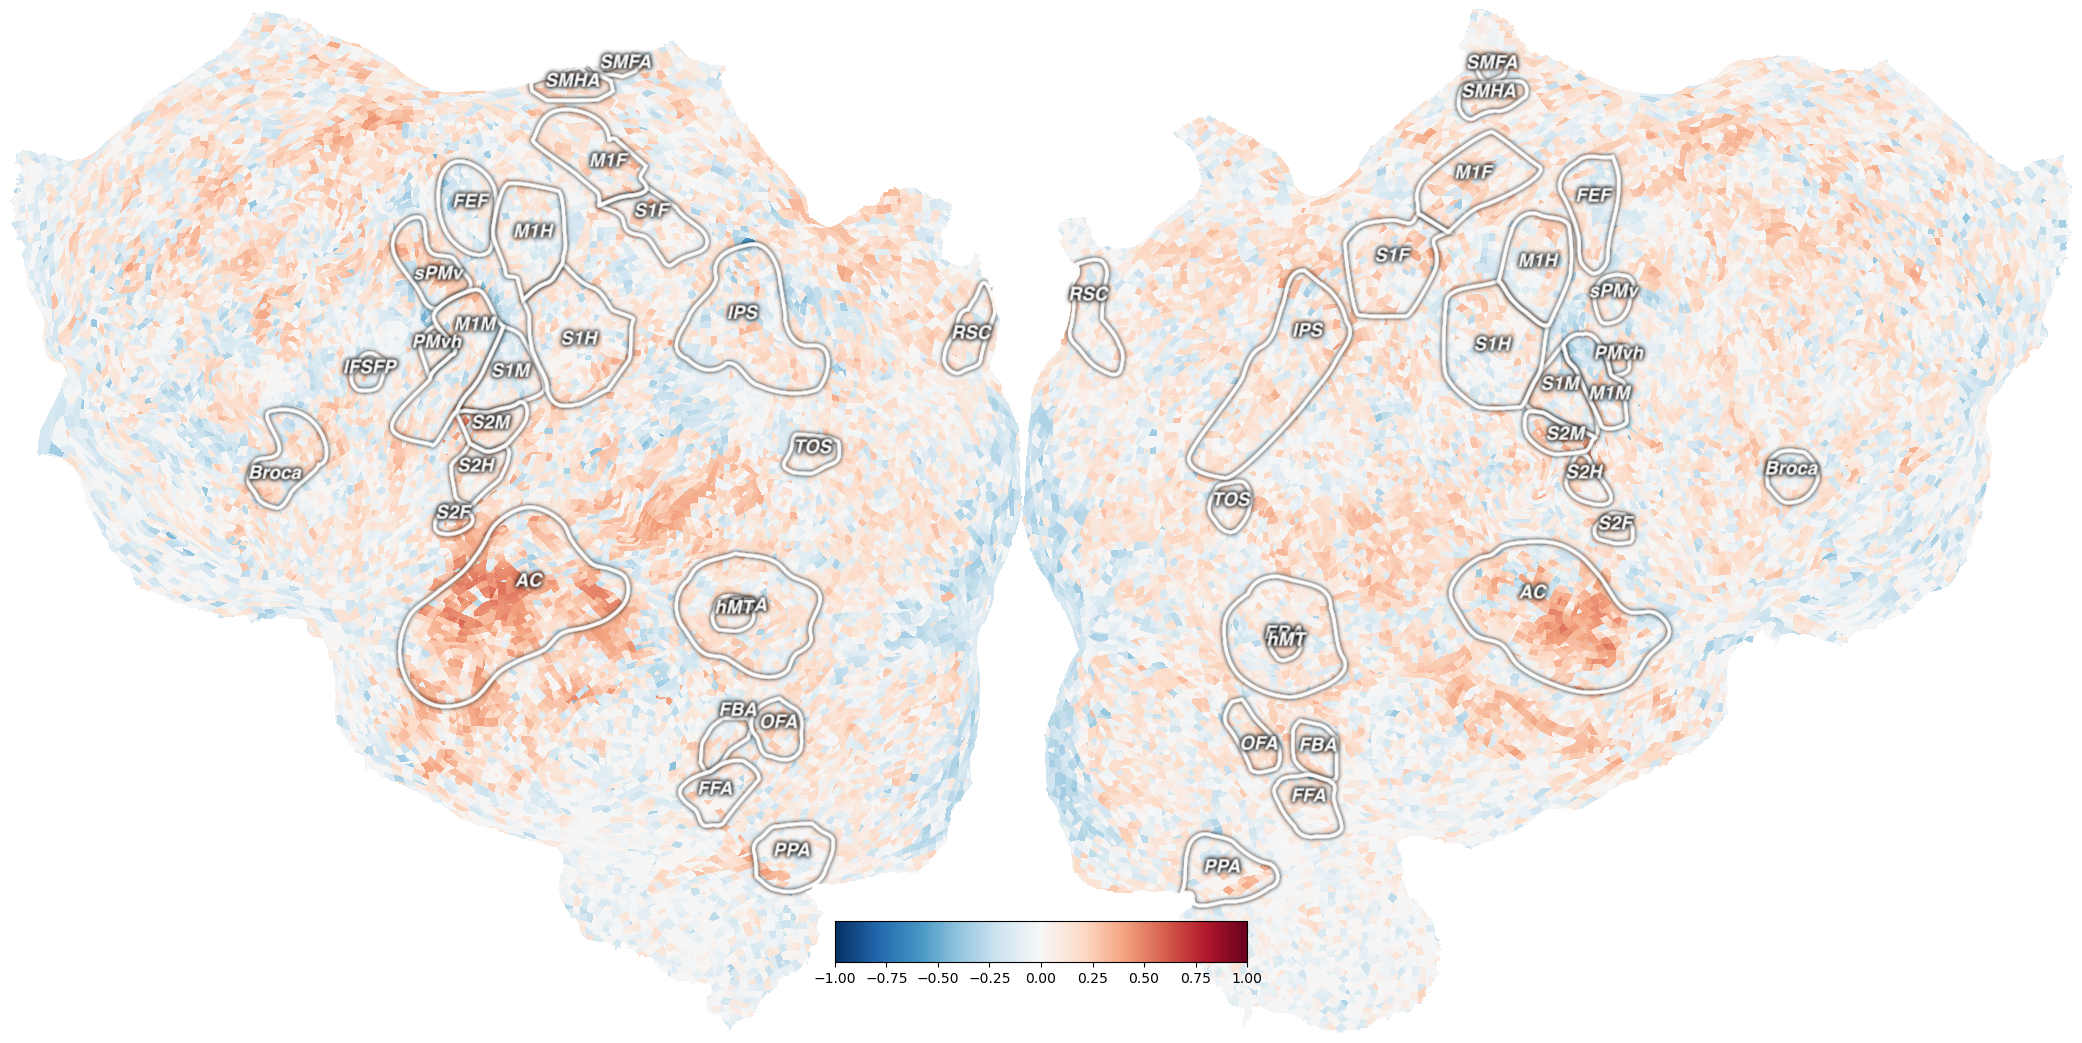

In [ ]:
vol = cortex.Volume(np.array(corr), 'UTS03', 'UTS03_auto', vmin=-1, vmax=1, )
cortex.quickshow(vol, with_colorbar=True, linewidth=4, thick=1, with_curvature=True, with_rois=True);